In [5]:
import tntorch as tn
import torch
import kaolin as kal
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [2]:
scene = torch.load('../logs/tucker_r40_00032_longshort_flying_eagle.pt')

In [3]:
def reduce_tucker(ts, eps, rmax, algorithm):
    d = dict()
    for i, elem in enumerate(ts):
        climb = 0  # For going up the tree
        while climb in d:
            elem = tn.round_tucker(tn.cat([d[climb], elem], dim=-1), eps=eps, rmax=rmax, algorithm=algorithm)
            d.pop(climb)
            climb += 1
        d[climb] = elem
    keys = list(d.keys())
    result = d[keys[0]]
    for key in keys[1:]:
        result = tn.round_tucker(tn.cat([result, d[key]], dim=-1), eps=eps, rmax=rmax, algorithm=algorithm)
    return result

In [6]:
rmax = 80
EPS = 1e-8
MIN_TSDF = -0.05
MAX_TSDF = 0.05
tt_tucker = reduce_tucker([t[..., None].to(torch.float64) for t in scene], EPS, rmax, 'svd')

In [7]:
tt_tucker

4D TT-Tucker tensor:

 512 512 512 284
  |   |   |   |
 80  80  80  80
 (0) (1) (2) (3)
 / \ / \ / \ / \
1   160 640080  1

In [11]:
torch.norm(
    tt_tucker[..., 0].torch().clamp_min(MIN_TSDF).clamp_max(MAX_TSDF) -
    scene[0].torch().clamp_min(MIN_TSDF).clamp_max(MAX_TSDF))

tensor(2.2838)

In [8]:
tt_tucker.ranks_tt

tensor([   1,  160, 6400,   80,    1])

In [13]:
truncated = tt_tucker.round_tt(rmax=512)

In [18]:
tt_tucker.ranks_tt

tensor([  1,  80, 512,  80,   1])

In [20]:
torch.norm(
    tt_tucker[..., 0].torch().clamp_min(MIN_TSDF).clamp_max(MAX_TSDF) -
    scene[0].torch().clamp_min(MIN_TSDF).clamp_max(MAX_TSDF))

tensor(2.9335)

In [149]:
# torch.save(tt_tucker, '../logs/tt_tucker_r40_00032_longshort_flying_eagle.pt')

In [146]:
tt_tucker

4D TT-Tucker tensor:

 512 512 512 284
  |   |   |   |
 80  80  80  80
 (0) (1) (2) (3)
 / \ / \ / \ / \
1   160 640080  1

In [147]:
tt_tucker.ranks_tucker, tt_tucker.ranks_tt

(tensor([80, 80, 80, 80]), tensor([   1,  160, 6400,   80,    1]))

In [145]:
torch.norm(tt_tucker[..., 0].torch() - scene[0].torch()) / torch.norm(scene[0].torch())

tensor(0.0021)

In [73]:
torch.norm(tt_tucker[..., 1].torch() - scene[1].torch())

tensor(58546.0647)

In [148]:
tt_tucker.numcoef() / tt_tucker.numel()

tensor(0.0032)

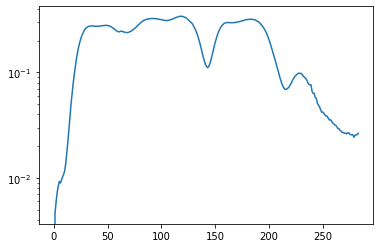

In [139]:
plt.figure()
plt.plot([torch.norm(s.torch() - scene[0].torch()) / torch.norm(scene[0].torch()) for s in scene])
plt.yscale('log')
plt.show()

In [1]:
# fname = '/scratch2/data/cape_release/meshes/00032/longshort_flying_eagle/posed/watertight_longshort_flying_eagle.000088.obj'

# mesh = kal.io.obj.import_mesh(fname)

In [127]:
MIN_TSDF = -0.05
MAX_TSDF = 0.05
t = tn.Tensor(sdf_field['sdf'].clamp_min(MIN_TSDF).clamp_max(MAX_TSDF), ranks_tucker=40)

In [128]:
torch.norm(t.torch() - sdf_field['sdf'].clamp_min(MIN_TSDF).clamp_max(MAX_TSDF)) / torch.norm(sdf_field['sdf'].clamp_min(MIN_TSDF).clamp_max(MAX_TSDF))

tensor(0.0054)

In [ ]:
# mesh_pred = trimesh.base.Trimesh(vertices=verts, faces=faces)

# obj = trimesh.exchange.export.export_obj(mesh_pred, include_texture=False)
# with open('mesh.obj', 'w') as f:
#     f.write(obj)